In [75]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

# Import

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Embedding, Flatten, Input, concatenate, Reshape
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
import tensorflow_hub as hub
import tensorflow_text as text

from matplotlib import pyplot as plt

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Настройки

In [78]:
DIR = '/content/drive/MyDrive/Colab Notebooks/DAN/Смарт-сайт/files/'

# Данные
Лейблы класса

In [79]:
data = pd.read_csv(DIR + 'data.csv', index_col=0)

In [80]:
data.head()

,question,class
0,виды разработки сайтов,0
1,время создания сайта,0
2,данные на создание сайта,0
3,задачи создания сайта,0
4,заказать интернет сайт,0


In [81]:
print(data.shape)

(2330, 2)


In [82]:
data_x = data['question']

In [83]:
data_y = to_categorical(data['class'], dtype='int')

In [84]:
classes_num = data_y.shape[1]
classes_num

41

# Загрузка модели BERT
Мы загрузим две модели, одну для предварительной обработки, а другую для кодирования. Ссылки на модели приведены ниже.

In [85]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4", trainable=True)

# Инициализация слоев BERT
В приведенном ниже коде мы создаем входной слой, используя tf.keras.layers.Input метод. Мы будем использовать в **preprocessed_text** качестве входных данных для этого слоя.

Затем **bert_encoder** функция преобразует предварительно обработанный текст в embadding векторы. Это будет выход этого слоя. Затем **outputs** они будут переданы в слои нейронной сети.

In [86]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

## Посмотрим на работу **preprocessed_text**

In [87]:
p_text = bert_preprocess(['Создание сайтов'])
p_text

{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[  101, 36852, 45076, 13541, 23285, 10433,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0, 

In [88]:
bert_encoder(p_text)

{'pooled_output': <tf.Tensor: shape=(1, 768), dtype=float32, numpy=
 array([[ 3.32351178e-01, -1.72285944e-01,  3.29328150e-01,
         -3.54896188e-01, -2.01404229e-01,  4.13335651e-01,
          3.43536317e-01,  2.14050919e-01, -4.26788270e-01,
          3.59309286e-01, -2.98414007e-02, -3.05066019e-01,
         -2.86325306e-01, -2.36799479e-01,  1.55280441e-01,
         -4.72096235e-01,  8.08936656e-01,  2.51211345e-01,
          2.60708094e-01, -4.54398930e-01, -9.99970496e-01,
         -5.26440322e-01, -4.04504240e-01, -1.51830748e-01,
         -7.17329204e-01,  6.59313425e-02, -1.61634058e-01,
          2.14907348e-01,  4.19674635e-01, -2.97631681e-01,
         -2.77904645e-02, -9.99972284e-01,  8.55660498e-01,
          7.91318595e-01,  3.20735425e-01, -5.16618013e-01,
          3.17619115e-01,  2.11185843e-01,  5.85126102e-01,
         -4.11135614e-01, -1.45509571e-01,  3.05804759e-01,
          9.89605859e-03,  2.35397089e-02, -1.17731847e-01,
         -3.14006627e-01, -3.218

# Слои нейронной сети

In [89]:
text_input = Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

x = outputs['pooled_output']
x = Dense(768, activation='relu')(x)
x = Dropout(0.25)(x)
x_output = Dense(41, activation='softmax')(x)

# Модель

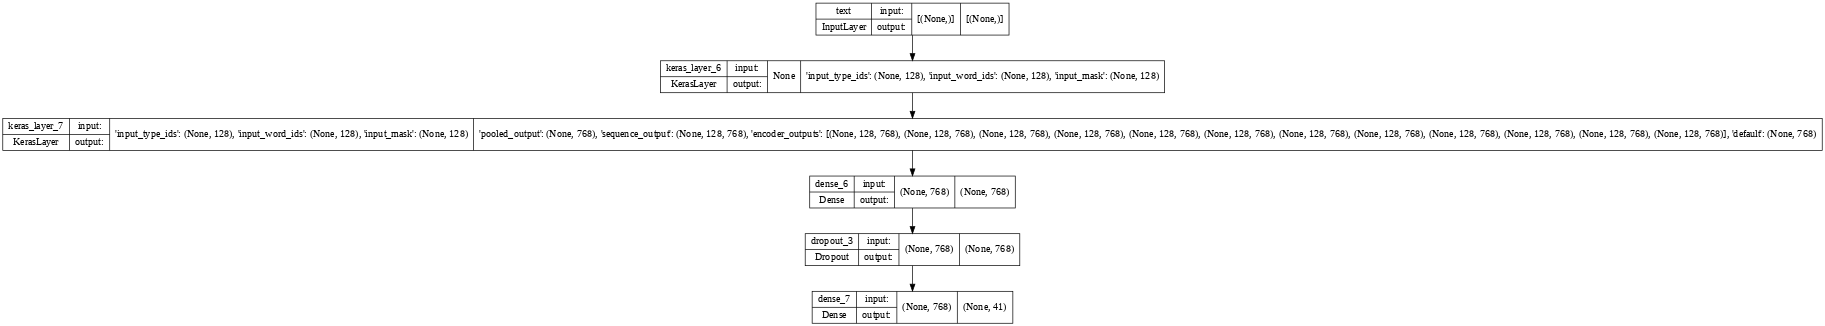

In [90]:
model = Model(inputs=[text_input], outputs = [x_output])
plot_model(model, show_shapes=True, expand_nested=True, show_layer_names=True, dpi=50)

In [91]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_6 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

# Компиляция модели

In [92]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=(0.000002)), metrics=['accuracy', 'AUC'])

# Обучение модели, train, test

In [93]:
x_train, x_test, y_train, y_test = train_test_split(data_x.to_list(), data_y.tolist(), test_size=0.1, random_state=12)

In [94]:
type(x_train)

list

In [95]:
x_train[0:10]

['seo продвижение в интернете',
 'wordpress api',
 'программа рассылки email',
 'email рассылка рекламы',
 'создание сетей сайтов',
 'делаете калькуляторы для сайта',
 'лучший веб дизайн',
 'email рассылка почты',
 'оптимизация интернет магазина',
 'настрой контекстной рекламы']

In [96]:
data_y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [97]:
history = model.fit(
  x_train,
  y_train, 
  epochs = 30,
  batch_size = 16,
  validation_data = (x_test, y_test),
  verbose = 1
)

Epoch 1/30
132/132 [==============================] - 75s 468ms/step - loss: 3.3551 - accuracy: 0.1822 - auc: 0.7161 - val_loss: 3.0354 - val_accuracy: 0.2318 - val_auc: 0.7792
Epoch 2/30
132/132 [==============================] - 61s 465ms/step - loss: 2.9197 - accuracy: 0.2880 - auc: 0.8180 - val_loss: 2.6131 - val_accuracy: 0.3734 - val_auc: 0.8573
Epoch 3/30
132/132 [==============================] - 62s 469ms/step - loss: 2.5262 - accuracy: 0.4006 - auc: 0.8751 - val_loss: 2.2602 - val_accuracy: 0.4678 - val_auc: 0.9023
Epoch 4/30
132/132 [==============================] - 62s 468ms/step - loss: 2.1872 - accuracy: 0.4974 - auc: 0.9164 - val_loss: 1.9897 - val_accuracy: 0.5494 - val_auc: 0.9251
Epoch 5/30
132/132 [==============================] - 62s 472ms/step - loss: 1.8900 - accuracy: 0.5866 - auc: 0.9446 - val_loss: 1.7470 - val_accuracy: 0.6223 - val_auc: 0.9451
Epoch 6/30
132/132 [==============================] - 63s 475ms/step - loss: 1.6500 - accuracy: 0.6624 - auc: 0.960

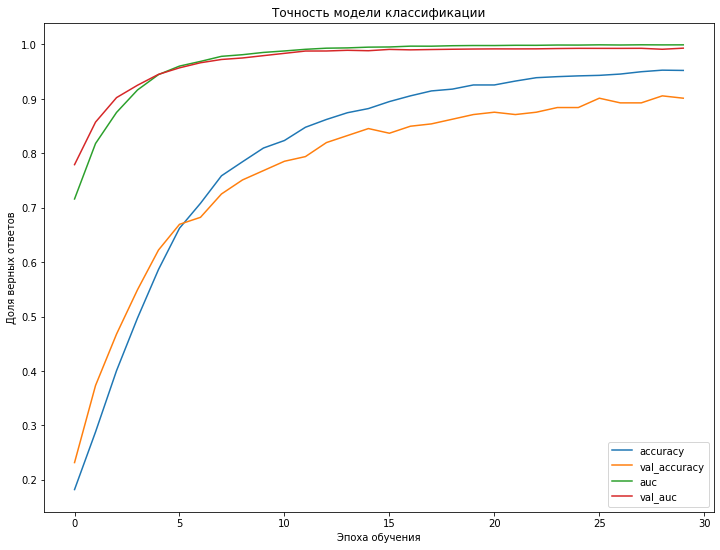

In [98]:
plt.figure(figsize=(12, 9))
plt.title('Точность модели классификации')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend(['accuracy', 'val_accuracy', 'auc', 'val_auc'])
plt.show()

In [100]:
score_train = model.evaluate(x_train, y_train)
score_test = model.evaluate(x_test, y_test)
print('TRAIN:', score_train)
print('TEST:', score_test)

8/8 [==============================] - 2s 283ms/step - loss: 0.3871 - accuracy: 0.9013 - auc: 0.9932
TRAIN: [0.1509605348110199, 0.9656652212142944, 0.9995912909507751]
TEST: [0.3871338665485382, 0.9012875556945801, 0.9932175278663635]


In [99]:
# model.save(DIR+'model_1.h5')